# Exploratory Data Analysis (EDA)
### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter

plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
tweet = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('tweet.shape: ', tweet.shape)
print('test.shape: ', test.shape)
tweet.head()

tweet.shape:  (7613, 5)
test.shape:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Class Distribution

Text(0, 0.5, 'samples')

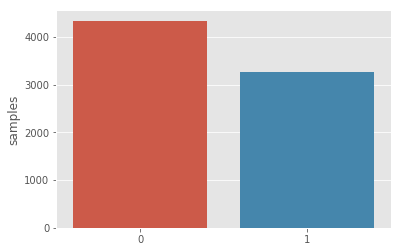

In [5]:
x = tweet.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

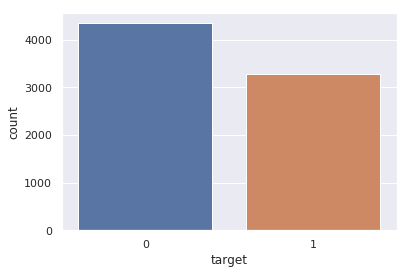

In [6]:
# Another way to do count plot in Seaborn
sns.set(style='darkgrid')
sns.countplot(x='target', data=tweet)

Almost similar number of records for both

### Number of characters, words, length

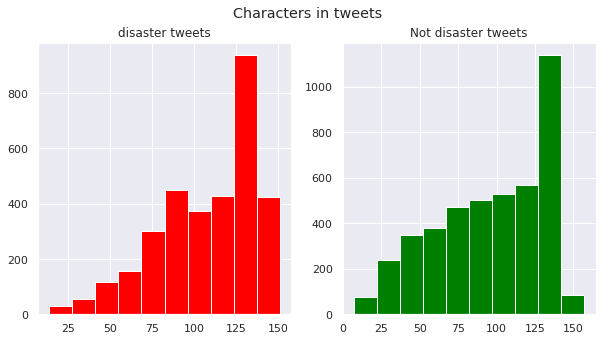

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Around 100-150 characters per tweet

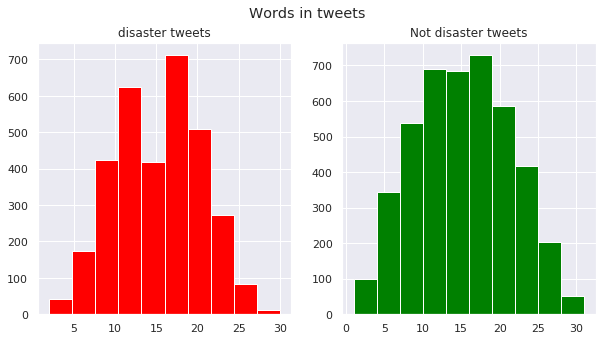

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in tweets')
plt.show()

Around 10-20 words per tweet

Text(0.5, 0.98, 'Average word lengths in each tweet')

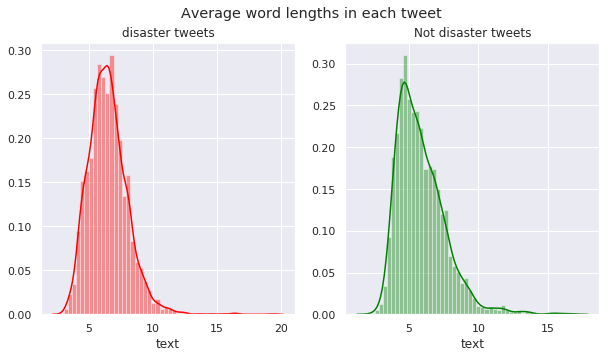

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = tweet[tweet['target']==1]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('disaster tweets')
word = tweet[tweet['target']==0]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Average word lengths in each tweet')

* Disaster - around 7 charactors per word
* Not disaster - around 5 charactors per word

### Common Stop Words

In [10]:
def create_corpus(target):
    corpus = []
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

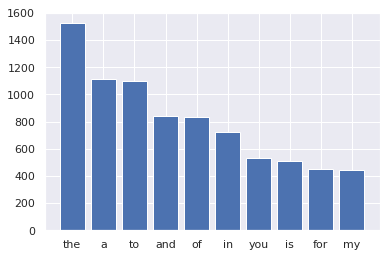

In [11]:
# Analyze Not disaster tweets
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.bar(x, y)

<BarContainer object of 10 artists>

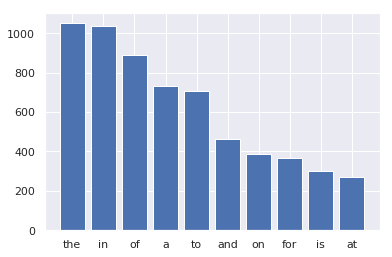

In [12]:
# Analyze disaster tweets
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.bar(x, y)

Not much difference between Disaster and Not disaster

### Punctuation

<BarContainer object of 20 artists>

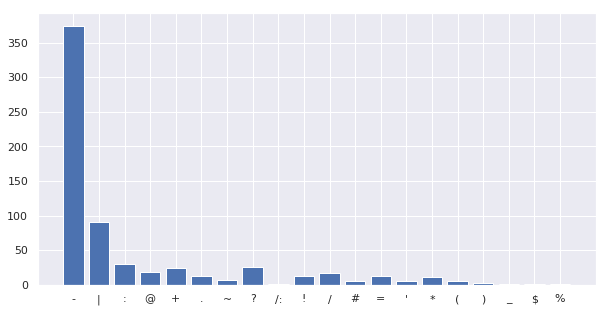

In [13]:
# Analyze Not disaster tweets
corpus = create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for word in corpus:
    if word in special:
        dic[word] += 1

x, y = zip(*dic.items())
plt.figure(figsize=(10, 5))
plt.bar(x, y)

<BarContainer object of 18 artists>

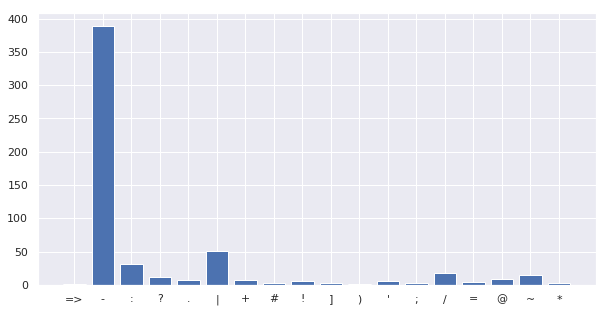

In [14]:
# Analyze disaster tweets
corpus = create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for word in corpus:
    if word in special:
        dic[word] += 1

x, y = zip(*dic.items())
plt.figure(figsize=(10, 5))
plt.bar(x, y)

### Common words not in stopwords

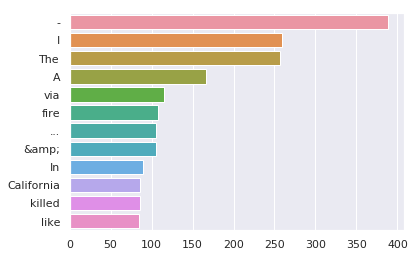

In [15]:
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

sns.barplot(x=y, y=x)

### Ngram analysis

In [16]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [17]:
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
top_tweet_bigrams

[('http co', 4306),
 ('https co', 410),
 ('in the', 308),
 ('of the', 256),
 ('û_ http', 217),
 ('on the', 129),
 ('to the', 126),
 ('to be', 108),
 ('for the', 97),
 ('at the', 85)]

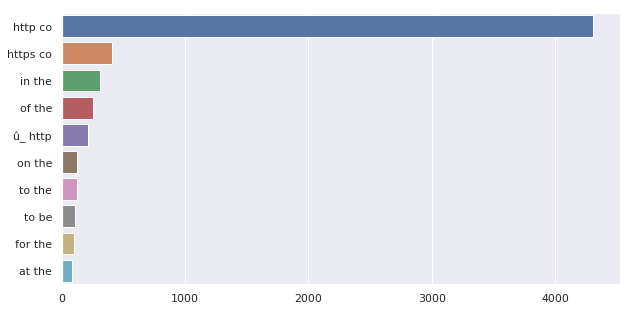

In [18]:
plt.figure(figsize=(10,5))
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)

### Hashtag Analysis

In [19]:
def find_hashtags(text):
    return ','.join(match.group(0)[1:].lower() for match in re.finditer(r'#\w+', text)) or None

def create_hashtag_corpus(target):
    corpus_ht = []
    hashtags = tweet[tweet['target']==target]['text'].apply(lambda x: find_hashtags(x))
    print('The number of tweets having hashtag(s): ', len([x for x in hashtags if isinstance(x, str)]))
    hashtags.fillna(value='no', inplace=True)
    
    for x in hashtags.str.split(','):
        for i in x:
            if i != 'no':
                corpus_ht.append(i)
    return corpus_ht

The number of tweets having hashtag(s):  885


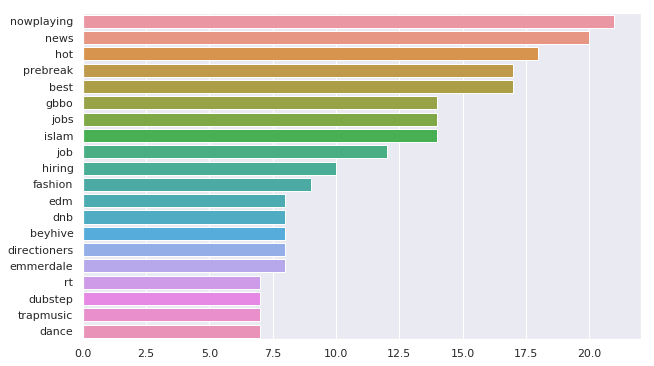

In [20]:
corpus_ht = create_hashtag_corpus(0)
dic = defaultdict(int)
for word in corpus_ht:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:20]
plt.figure(figsize=(10,6))
x, y = map(list, zip(*top))
sns.barplot(x=y, y=x)

The number of tweets having hashtag(s):  858


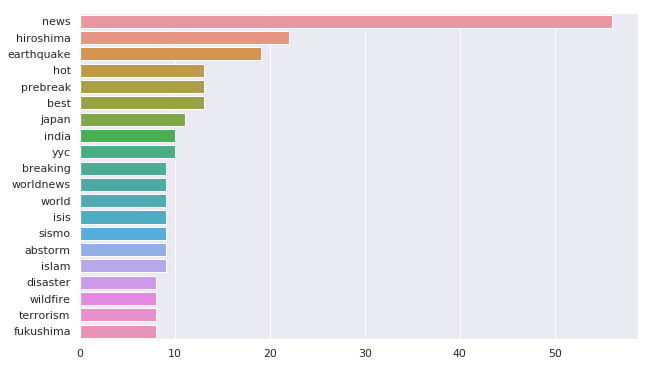

In [21]:
corpus_ht = create_hashtag_corpus(1)
dic = defaultdict(int)
for word in corpus_ht:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:20]
plt.figure(figsize=(10,6))
x, y = map(list, zip(*top))
sns.barplot(x=y, y=x)

## Feature Analysis
### Keyword

In [22]:
#Remove the encoded space character
tweet['keyword'] = tweet['keyword'].map(lambda s: s.replace('%20', ' ') if isinstance(s, str) else s)

kw_unique  = {kw for kw in tweet['keyword'].values if isinstance(kw, str)}
kw_total = len(tweet) - len(tweet[tweet["keyword"].isna()])

print("Unique Keyword / Total: {} / {}".format(len(kw_unique), kw_total))
print("Tweets with no keyword: {}".format(len(tweet[tweet["keyword"].isna()])))

Unique Keyword / Total: 221 / 7552
Tweets with no keyword: 61


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

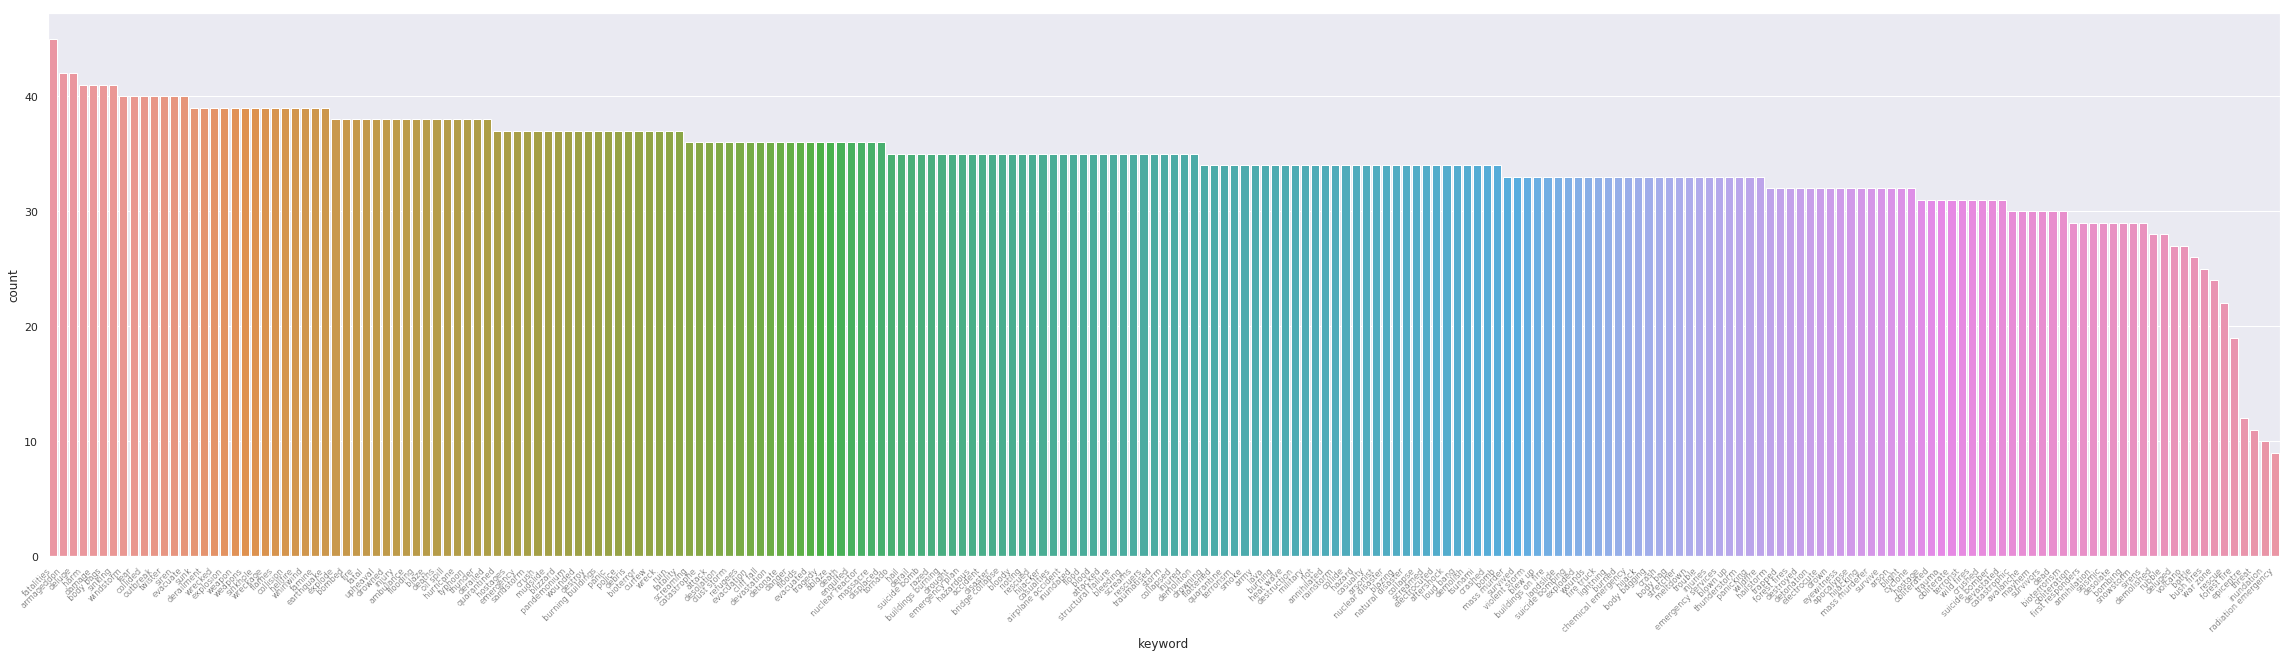

In [23]:
plt.figure(figsize=(40,10))
g = sns.countplot(x="keyword", data=tweet, order=tweet['keyword'].value_counts().index)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

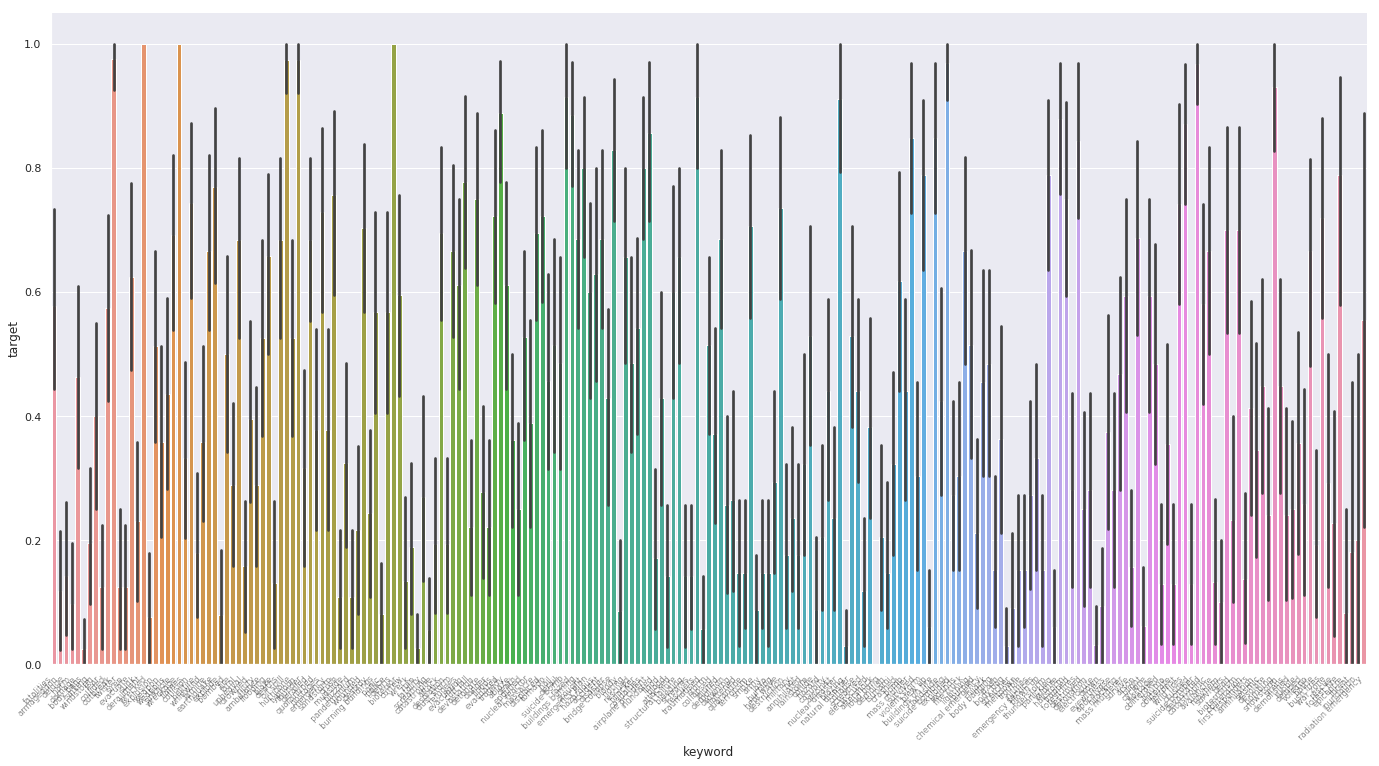

In [34]:
g = sns.factorplot(y='target', x='keyword', data=tweet, kind='bar', height=10, aspect=2, order=tweet['keyword'].value_counts().index)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

In [25]:
kw_disaster = [kw for kw in tweet.loc[tweet.target == 1].keyword]
kw_not_disaster = [kw for kw in tweet.loc[tweet.target == 0].keyword]

kw_disaster_cn = dict(pd.DataFrame(data={'x': kw_disaster}).x.value_counts())
kw_not_disaster_cn = dict(pd.DataFrame(data={'x': kw_not_disaster}).x.value_counts())
kw_all_cn =  dict(pd.DataFrame(data={'x': tweet.keyword.values}).x.value_counts())

for keyword, _ in sorted(kw_all_cn.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("> Keyword: {}".format(keyword))
    print("-- # in disaster tweets:     {}".format(kw_disaster_cn.get(keyword, 0)))
    print("-- # in not disaster tweets: {}".format(kw_not_disaster_cn.get(keyword, 0)))
    print('--------')

> Keyword: fatalities
-- # in disaster tweets:     26
-- # in not disaster tweets: 19
--------
> Keyword: armageddon
-- # in disaster tweets:     5
-- # in not disaster tweets: 37
--------
> Keyword: deluge
-- # in disaster tweets:     6
-- # in not disaster tweets: 36
--------
> Keyword: harm
-- # in disaster tweets:     4
-- # in not disaster tweets: 37
--------
> Keyword: damage
-- # in disaster tweets:     19
-- # in not disaster tweets: 22
--------
> Keyword: body bags
-- # in disaster tweets:     1
-- # in not disaster tweets: 40
--------
> Keyword: sinking
-- # in disaster tweets:     8
-- # in not disaster tweets: 33
--------
> Keyword: windstorm
-- # in disaster tweets:     16
-- # in not disaster tweets: 24
--------
> Keyword: fear
-- # in disaster tweets:     5
-- # in not disaster tweets: 35
--------
> Keyword: collided
-- # in disaster tweets:     23
-- # in not disaster tweets: 17
--------


* Most of keywords have 30-40 samples
* Some are strongly correlated to target, while others are not.
* So, use only those correlated keywords only

### Location

In [35]:
loc_unique  = {loc for loc in tweet['location'].values if isinstance(loc, str)}
loc_total = len(tweet) - len(tweet[tweet["location"].isna()])

print("Unique Location / Total: {} / {}".format(len(loc_unique), loc_total))
print("Tweets with no Location: {}".format(len(tweet[tweet["location"].isna()])))

Unique Location / Total: 3341 / 5080
Tweets with no Location: 2533


In [38]:
loc_disaster = [loc for loc in tweet.loc[tweet.target == 1].location]
loc_not_disaster = [loc for loc in tweet.loc[tweet.target == 0].location]

loc_disaster_cn = dict(pd.DataFrame(data={'x': loc_disaster}).x.value_counts())
loc_not_disaster_cn = dict(pd.DataFrame(data={'x': loc_not_disaster}).x.value_counts())
loc_all_cn =  dict(pd.DataFrame(data={'x': tweet.location.values}).x.value_counts())

for location, _ in sorted(loc_all_cn.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("> Location: {}".format(location))
    print("-- # in disaster tweets:     {}".format(loc_disaster_cn.get(location, 0)))
    print("-- # in not disaster tweets: {}".format(loc_not_disaster_cn.get(location, 0)))
    print('--------')

> Location: USA
-- # in disaster tweets:     67
-- # in not disaster tweets: 37
--------
> Location: New York
-- # in disaster tweets:     16
-- # in not disaster tweets: 55
--------
> Location: United States
-- # in disaster tweets:     27
-- # in not disaster tweets: 23
--------
> Location: London
-- # in disaster tweets:     16
-- # in not disaster tweets: 29
--------
> Location: Canada
-- # in disaster tweets:     13
-- # in not disaster tweets: 16
--------
> Location: Nigeria
-- # in disaster tweets:     22
-- # in not disaster tweets: 6
--------
> Location: UK
-- # in disaster tweets:     16
-- # in not disaster tweets: 11
--------
> Location: Los Angeles, CA
-- # in disaster tweets:     8
-- # in not disaster tweets: 18
--------
> Location: India
-- # in disaster tweets:     20
-- # in not disaster tweets: 4
--------
> Location: Mumbai
-- # in disaster tweets:     19
-- # in not disaster tweets: 3
--------


We may use this but the data is too sparce

# Data Cleaning
* Remove URLs
* Remove HTML Tags
* Remove Emoji
* Remove Punctuations

In [ ]:
df = pd.concat([tweet, test])
print(df.shape)
df

### Removing URLs

In [ ]:
example="This is a test message :https://www.abc.com/test/sample-project"

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

remove_URL(example)

In [ ]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

### Removing HTML tags

In [ ]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

print(remove_html(example))

In [ ]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

### Removing Emojis

In [ ]:
example = "Omg another Earthquake 😔😔"

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji(example)

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### Removing punctuations

In [ ]:
example="I am a #king"

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

print(remove_punct(example))

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

# Model, Train and Predict
## Utility

In [ ]:
def test_save(model, test, name_pre='test'):
    sample_sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
    if type(test) == pd.DataFrame:
        y_pre = model.predict(test.text)
    else:
        y_pre = model.predict(test)
    y_pre = np.round(y_pre).astype(int).reshape(3263)
    sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
    sub_name = name_pre + "_submission.csv"
    sub.to_csv(sub_name, index=False)

## A) tfidf + Logistic Regression as a baseline model

In [ ]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def build_tfidf_logreg(df, validation=False):
    x_train = df['text']
    y_train = df['target']
    clf = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word')),
        ('clf', LogisticRegression())
        ])

    if validation:
        x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train.values, y_train.values, test_size=0.2, random_state=7)
        print(x_train, y_train)
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        predicted_valid = clf.predict(x_valid)
        print("Training Accuracy: ", np.mean(predicted_train == y_train))
        print("Validation Accuracy: ", np.mean(predicted_valid == y_valid))
    
    else:
        clf.fit(x_train, y_train)
    
    return clf

train_df = df[:tweet.shape[0]]
test_df = df[tweet.shape[0]:]

model = build_tfidf_logreg(train_df, validation=False)

test_save(model, test_df, "a_tfidf_logreg")

## B) Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_gradboost(df, validation=False):
    x_train = df['text']
    y_train = df['target']
    clf = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word')),
        ('clf', GradientBoostingClassifier())
        ])

    if validation:
        x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train.values, y_train.values, test_size=0.2, random_state=7)
        print(x_train, y_train)
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        predicted_valid = clf.predict(x_valid)
        print("Training Accuracy: ", np.mean(predicted_train == y_train))
        print("Validation Accuracy: ", np.mean(predicted_valid == y_valid))
    
    else:
        clf.fit(x_train, y_train)
    
    return clf

train_df = df[:tweet.shape[0]]
test_df = df[tweet.shape[0]:]

model = build_tfidf_gradboost(train_df, validation=False)

test_save(model, test_df, "b_tfidf_gradboost")

## C) GloVe + LSTM
### GloVe Word Embedding

In [ ]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [ ]:
corpus = create_corpus(df)

In [ ]:
os.listdir('../input/glove-global-vectors-for-word-representation/')

In [ ]:
# Load a Lookup table
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [ ]:
# Tokenize corpus
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
print(sequences)
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
print(tweet_pad)

In [ ]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

In [ ]:
# Embed words
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 200))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
        
    embed_vec = embedding_dict.get(word)
    if embed_vec is not None:
        embedding_matrix[i] = embed_vec

### Model and Test

In [ ]:
model = Sequential()

embedding = Embedding(num_words, 200, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

In [ ]:
train = tweet_pad[:tweet.shape[0]]
test = tweet_pad[tweet.shape[0]:]

X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

In [ ]:
test_save(model, test, "c_GloVe_LSTM")